# Модель для предсказания продолжительности отключения станции (в минутах)

Команда: MYNI

Состав участников:
- Сарафанов Михаил - mik_sar@mail.ru
- Борисова Юлия - yulashka.htm@yandex.ru
- Власова Наталья - natalya9vlasova@gmail.com
- Макаркина Ирина - irid.life@gmail.com

Задача: Предложить и программно реализовать математическую модель, которая на основании накопленной прежде статистики о выходе станций из строя будет предсказывать продолжительность отключения станции от сети в той или иной локации в пределах заданной территории. И самостоятельно оценить качество работы предложенной модели.

Для визуализации результатов предсказаний модели был разработан веб-сервис - http://ec2-34-222-5-52.us-west-2.compute.amazonaws.com:1500/
(разработчик - Борисова Юлия)

Ниже приведен программный код и изложены основные идеи, которые мы рассматривали за время работы над проектом. Стоит заметить, что ниже показан один, наиболее эффективный из рассмотренных, алгоритм машинного обучения / подход к построению предсказательной модели.

Ссылка на страницу с материалами для финального этапа: https://1.changellenge.com/cup-it/final

In [59]:
# Необходимые библиотеки
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
from datetime import datetime
from pyproj import Proj, transform
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, Ridge, PassiveAggressiveRegressor, SGDRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import RANSACRegressor
import pickle

from datetime import date
import warnings
warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8

## 1. Загрузка обучающей выборки

In [60]:
# Загружаем исходный датасет
data = pd.read_csv('/media/mikhail/Data/Cup2020/Final/CL_megafon_Cup IT_2020_final_data.csv', sep = ';',
            dtype = {'place_latitude': float, 'place_longitude': float})

# Переводим нужные столбцы в формат datetime
data['time_start'] = pd.to_datetime(data['time_start'])
data['time_end'] = pd.to_datetime(data['time_end'])

print('Размер датасета -', data.shape)
data.head(5)

Размер датасета - (78223, 4)


,time_start,time_end,place_latitude,place_longitude
0,2019-08-24 14:23:56,2019-08-24 18:54:47,28.102908,113.617867
1,2018-06-19 08:56:22,2018-06-19 12:15:26,28.102908,113.617867
2,2018-08-29 14:00:32,2018-08-29 14:37:51,28.102908,113.617867
3,2019-12-10 16:01:26,2019-12-10 16:35:22,28.102908,113.617867
4,2019-12-10 13:39:42,2019-12-10 17:58:22,28.999495,115.167583


Как видно из первых 5 строк таблицы с данными, мы имеем координату широты и координату долготы для каждого объекта. А также мы знаем время начала сбоя и время его окончания. При этом целевую переменную нам ещё предстоит рассчитать.

## 2. Сортировка строк нужным образом, размер датасета при этом никак не изменяется.

Сформируем таблицу так, чтобы для каждой станции время начала сбоя было расположено по возрастанию.

In [61]:
data = data.groupby(['place_longitude', 'place_latitude', 'time_start']).agg({'time_end': 'first'})
data = data.reset_index()
print('Размер датасета -', data.shape)

Размер датасета - (78223, 4)


Как видно, дейтсвительно, размер датасета действительно не изменился.

## 3. Рассчет целевой переменной

Время продолжительности остановки будет рассчитанно в минутах

In [62]:
data['outage_time'] = data['time_end'] - data['time_start'] 
outage = []
for i in data['outage_time']:
    # Время в секундах
    sec_time = i.total_seconds()
    # Время в минутах
    min_time = sec_time/60
    outage.append(min_time)    
outage = np.array(outage)
data['outage'] = outage
# Уберем уже не нужный нам столбец
data.drop(columns = 'outage_time', inplace = True)
data.head(5)

,place_longitude,place_latitude,time_start,time_end,outage
0,111.01,31.96447,2018-03-12 14:24:43,2018-03-12 17:26:54,182.183333
1,111.01,31.96447,2018-03-30 09:16:33,2018-03-30 10:33:58,77.416667
2,111.01,31.96447,2018-07-24 10:18:12,2018-07-24 11:05:42,47.500000
3,111.01,31.96447,2018-07-25 15:25:34,2018-07-25 16:22:57,57.383333
4,111.01,31.96447,2018-09-19 11:57:56,2018-09-19 13:09:44,71.800000


## 3. Синтез нового категориального признака - время суток начала сбоя

Возможно, время суток может каким-либо образом повлиять на продолжительность отключения. Бригады в ночные смены, возможно, реагируют и добираются до места быстрее, или медленее, и т.д.

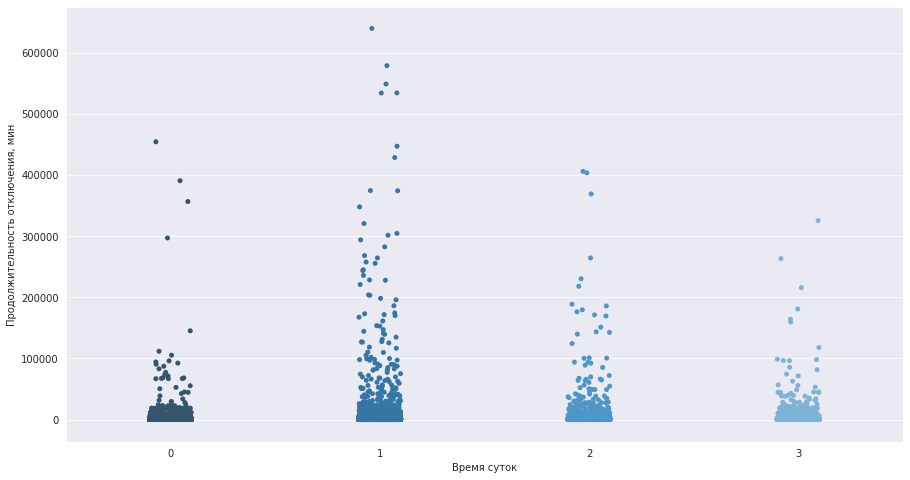

In [63]:
hours = []
year_and_month = []
for time in data['time_start']:
    time = datetime.strftime(time, format = "%Y-%m-%d %H:%M:%S")    
    # Используем только час
    hour = int(time[10:13])
    
    if any(hour == value for value in [0,1,2,3,4,5,6]):
        # Ночные часы и раннее утро
        hours.append('0')
    elif any(hour == value for value in [7,8,9,10,11,12,13]):
        # Утро и день
        hours.append('1')
    elif any(hour == value for value in [14,15,16,17]):
        # Вторая половина дня и начало вечера
        hours.append('2')
    else:
        # Вечернее время
        hours.append('3')
        
    # Теперь займемся разделением выборки на обучение и тест
    # Для теста возьмем один месяц в 2020 году, так будет честно
    year_and_month.append(time[:7])
data['hour'] = hours
data['year_and_month'] = year_and_month

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize = (15,8))
    sns.catplot('hour', 'outage', palette = "Blues_d", data = data, ax = ax)
    ax.set_xlabel('Время суток')
    ax.set_ylabel('Продолжительность отключения, мин')
    plt.close(2)
    plt.show()

0 - Ночные часы и раннее утро

1 - Утро и день

2 - Вторая половина дня и начало вечера

3 - Вечернее время

### Визуализация исходного набора данных

Переведем для удобства продолжительность сбоя из минут в часы и визуализируем нашу выборку.

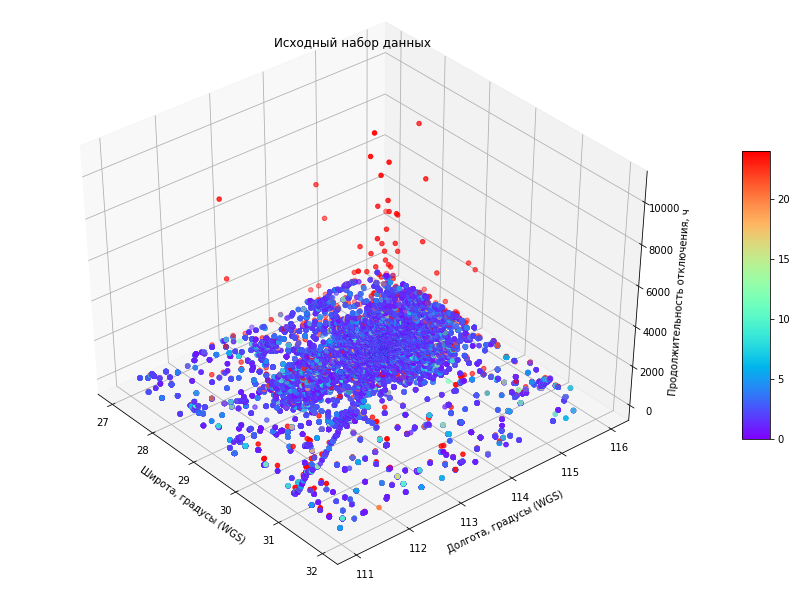

In [64]:
# Переведем продолжительность сбоя из минут в часы 
outage_hours = np.array(data['outage'])/60

# Сначала покажем все точки в 3d виде
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

fig = pyplot.figure()
ax = Axes3D(fig)

x_vals = np.array(data['place_latitude'])
y_vals = np.array(data['place_longitude'])
z_vals = np.array(outage_hours)
points = np.ravel(z_vals)

surf = ax.scatter(x_vals, y_vals,z_vals, c=points, cmap='rainbow', vmin = 0, vmax = 24)
ax.set_zlabel('Продолжительность отключения, ч')
ax.view_init(40, -40)
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.xlabel('Широта, градусы (WGS)')
plt.ylabel('Долгота, градусы (WGS)')
plt.title('Исходный набор данных')
pyplot.show()

Итак, у нас имеется некоторый центр, в котором сбои наиболее продолжительны, при этом на всей остальной территории подобной закономерности в явном виде не наблюдается.

### Визуализация исходного набора данных. Минимальное, среднее и максимальное значение продолжительности отключения для каждой станции.

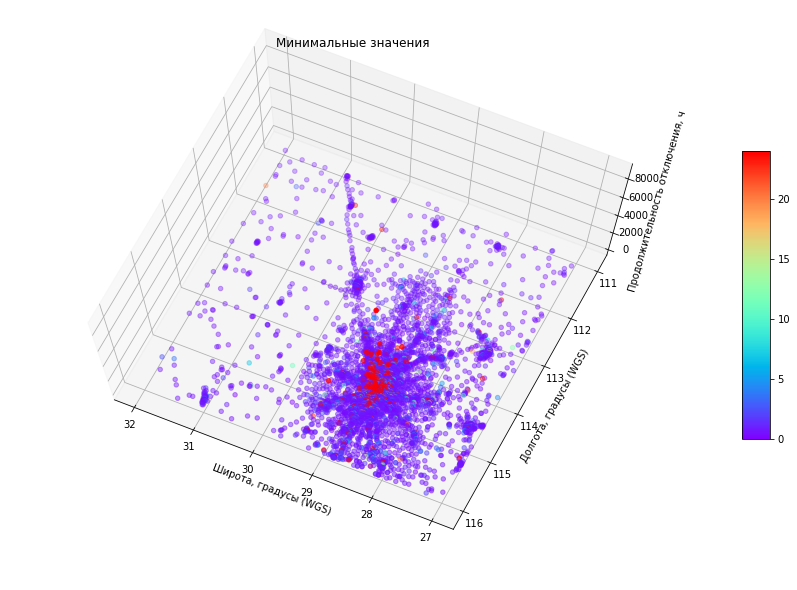

In [65]:
# Запишем новый столбец в датафрейм
data['outage_hours'] = outage_hours

# Агрегируем данные - возьмем минимальное, среднее и максимальное значение
dataframe_min = data.groupby(['place_longitude', 'place_latitude']).agg({'outage_hours': 'min',
                                                                          'outage': 'min'})
dataframe_min = dataframe_min.reset_index()

fig = pyplot.figure()
ax = Axes3D(fig)

x_vals = np.array(dataframe_min['place_latitude'])
y_vals = np.array(dataframe_min['place_longitude'])
z_vals = np.array(dataframe_min['outage_hours'])
points = np.ravel(z_vals )

surf = ax.scatter(x_vals, y_vals,z_vals, c=points, cmap='rainbow', vmin = 0, vmax = 24)
ax.set_zlabel('Продолжительность отключения, ч')
ax.view_init(75, 115)
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.xlabel('Широта, градусы (WGS)')
plt.ylabel('Долгота, градусы (WGS)')
plt.title('Минимальные значения')
pyplot.show()

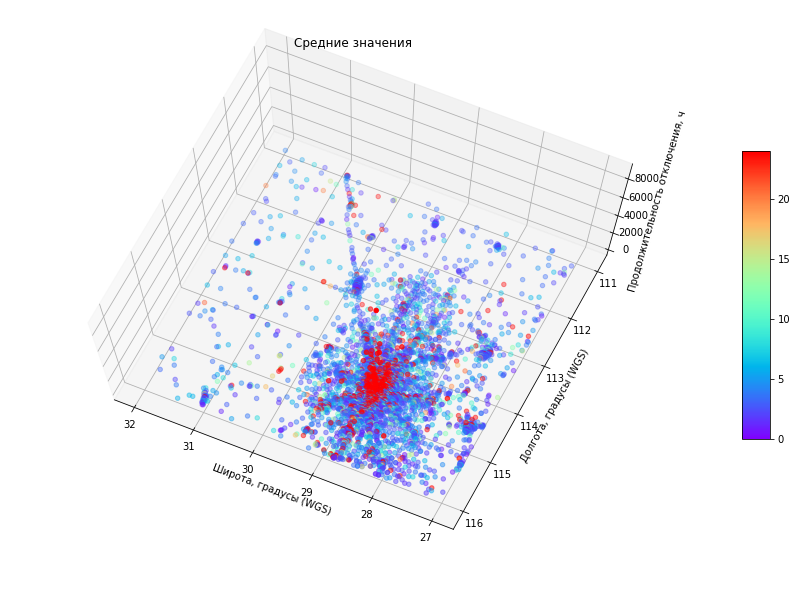

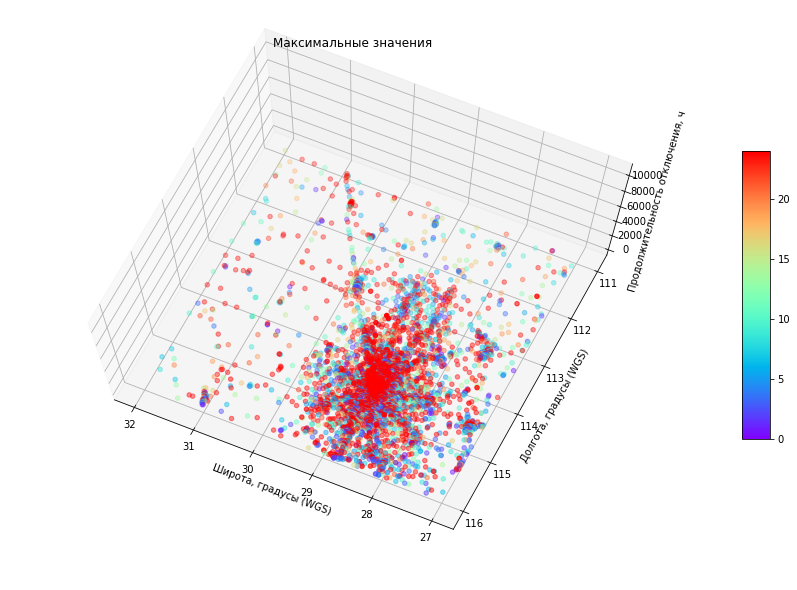

In [66]:
dataframe_mean = data.groupby(['place_longitude', 'place_latitude']).agg({'outage_hours': 'mean',
                                                                          'outage': 'mean'})
dataframe_mean = dataframe_mean.reset_index()

fig = pyplot.figure()
ax = Axes3D(fig)

x_vals = np.array(dataframe_mean['place_latitude'])
y_vals = np.array(dataframe_mean['place_longitude'])
z_vals = np.array(dataframe_mean['outage_hours'])
points = np.ravel(z_vals )

surf = ax.scatter(x_vals, y_vals,z_vals, c=points, cmap='rainbow', vmin = 0, vmax = 24)
ax.set_zlabel('Продолжительность отключения, ч')
ax.view_init(75, 115)
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.title('Средние значения')
plt.xlabel('Широта, градусы (WGS)')
plt.ylabel('Долгота, градусы (WGS)')
pyplot.show()


dataframe_max = data.groupby(['place_longitude', 'place_latitude']).agg({'outage_hours': 'max',
                                                                          'outage': 'max'})
dataframe_max = dataframe_max.reset_index()

fig = pyplot.figure()
ax = Axes3D(fig)

x_vals = np.array(dataframe_max['place_latitude'])
y_vals = np.array(dataframe_max['place_longitude'])
z_vals = np.array(dataframe_max['outage_hours'])
points = np.ravel(z_vals )

surf = ax.scatter(x_vals, y_vals,z_vals, c=points, cmap='rainbow', vmin = 0, vmax = 24)
ax.set_zlabel('Продолжительность отключения, ч')
ax.view_init(75, 115)
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.xlabel('Широта, градусы (WGS)')
plt.ylabel('Долгота, градусы (WGS)')
plt.title('Максимальные значения')
pyplot.show()

|Покажем связь между временем начала сбоя и его продолжительностью

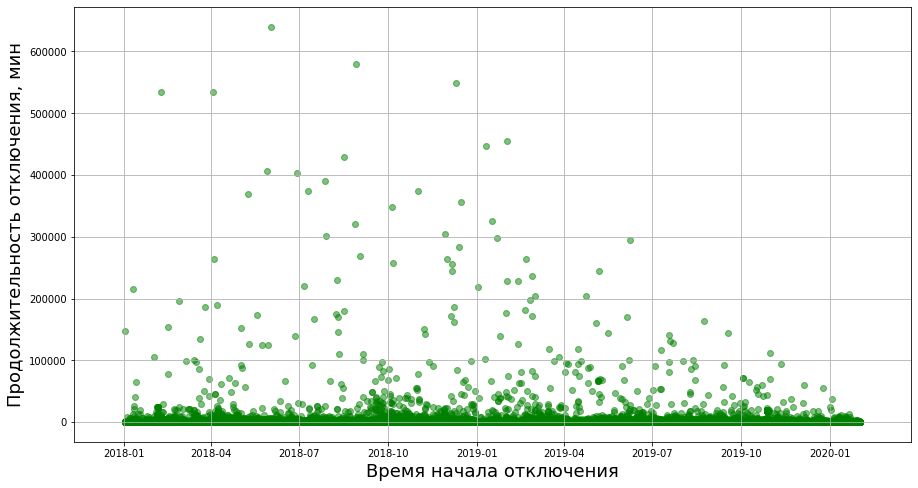

In [67]:
rcParams['figure.figsize'] = 15, 8

plt.scatter(data['time_start'], data['outage'], c = 'green', alpha = 0.5)
plt.xlabel('Время начала отключения', fontsize = 18)
plt.ylabel('Продолжительность отключения, мин', fontsize = 18)
plt.grid()
plt.show()

## 4. Разделение выборки на "обучение" и "тест"

Тестировать мы будем по данным за месяц январь 2020 года

In [68]:
# Тестовая выборка
test_data = data[data.year_and_month == '2020-01']
# Убираем из тестовой выборки очень большие значения как выбросы (порог - 2 000 минут)
test_data = test_data[test_data.outage < 2000]

# Обучающая выборка
train_data = data[data.year_and_month != '2020-01']
# Из обучающей выборки уберем явные выбросы
train_data = train_data[train_data.outage < 10000]

ВСЕ ПРЕОБРАЗОВАНИЯ ДАЛЕЕ ИДУТ ИСКЛЮЧИТЕЛЬНО С ТРЕНИРОВОЧНОЙ ВЫБОРКОЙ

## 5. Формируем столбец с начальной точкой отсчета

Так как в датасете одна и та же станция входит в обучающую выборку несколько раз с разными временными метками (временем начала сбоя), то мы можем использовать информацию о времени, прошедшем с начала предыдущего сбоя на этой станции. Для этой цели формируется точка отсчета времени, чтобы перейти от формата datetime в абсолютные величины (например, прошло 20 000 минут от точки отсчета до данного события). 

Точка отсчета - день моего 20летия -30е декабря 2017 года

In [69]:
start_point = []
for i in range(0, len(train_data['time_start'])):
    my_date = date(2017, 12, 30)
    start_point.append(my_date)
train_data['start_point'] = start_point
train_data['start_point'] = pd.to_datetime(train_data['start_point'])

## 6. Переводим время начала и конца сбоя в абсолютные единицы

In [70]:
# Теперь вычитаем значение столбца start_point из time_start - для времени начала сбоя
abs_time_start = train_data['time_start'] - train_data['start_point']
new_time_start = []
for i in abs_time_start:
    # Время в секундах
    sec_time = i.total_seconds()
    # Время в минутах
    min_time = sec_time/60
    new_time_start.append(min_time)    
train_data['abs_time_start'] = new_time_start

train_data.drop(columns = 'start_point', inplace = True)
train_data.head(5)

,place_longitude,place_latitude,time_start,time_end,outage,hour,year_and_month,outage_hours,abs_time_start
0,111.01,31.96447,2018-03-12 14:24:43,2018-03-12 17:26:54,182.183333,2,2018-03,3.036389,104544.716667
1,111.01,31.96447,2018-03-30 09:16:33,2018-03-30 10:33:58,77.416667,1,2018-03,1.290278,130156.550000
2,111.01,31.96447,2018-07-24 10:18:12,2018-07-24 11:05:42,47.500000,1,2018-07,0.791667,297258.200000
3,111.01,31.96447,2018-07-25 15:25:34,2018-07-25 16:22:57,57.383333,2,2018-07,0.956389,299005.566667
4,111.01,31.96447,2018-09-19 11:57:56,2018-09-19 13:09:44,71.800000,1,2018-09,1.196667,379437.933333


## 7. Преобразование координат

В координатной системе WGS 1 градус широты не равен 1 градусу долготы, так как для представленной территории 1° широты в системе WGS ≈ 96 км и 1° долготы равен 111.3 км. Таким образом, чтобы строить алгоритм на неискаженном пространстве признаков, необходимо перейти в другую систему координат, где расстояние измеряется в метрах.

Была выбрана Универсальная поперечная проекция Меркатора, зона UTM 32649. Преобразование координат осуществляется с использованием следующей функции:

In [71]:
# extent_dictionary ---
# словарь формата {'min_lat': ..., 'min_long': ...,'max_lat': ..., 'max_long': ...}, где указаны координаты в WGS
# old_lats --- массив из координат широт
# old_lons --- массив из координат долгот
def transform_wgs_to_utm(extent_dictionary, old_lats, old_longs):
    # Долгота - эта как ось X
    minX = extent_dictionary.get('min_long')
    # Широта - эта ось Y
    minY = extent_dictionary.get('min_lat')
    maxX = extent_dictionary.get('max_long')
    maxY = extent_dictionary.get('max_lat')

    y_centroid = (minY + maxY) / 2
    # 326NN или 327NN- где NN это номер зоны
    if y_centroid < 0:
        base_code = 32700
    else:
        base_code = 32600

    x_centroid = (minX + maxX) / 2
    zone = int(((x_centroid + 180) / 6.0) % 60) + 1
    utm_code = base_code + zone
    
    # Исходная проекция - WGS84 
    wgs = Proj(init="epsg:4326")
    # Метрическая проекция, в которую следует перепроецировать координаты
    utm = Proj(init="epsg:" + str(utm_code))
    print('Код подобранной метрической проекции UTM -', utm_code)
    
    # Осуществляем трансформацию координат
    new_lats = []
    new_longs = []
    for i in range(0, len(old_longs)):
        # Собираем пару координат
        wgs_long = old_longs[i]
        wgs_lat = old_lats[i]
        # Производим трансформацию 
        transformed_coord = transform(wgs, utm, *[wgs_long, wgs_lat])
        new_longs.append(transformed_coord[0])
        new_lats.append(transformed_coord[1])
    
    return(new_lats, new_longs)

По значениям из датасета проведем преобразование.

In [72]:
# Сначала широта 
min_lat = np.min(np.array(train_data['place_latitude']))
max_lat = np.max(np.array(train_data['place_latitude']))

# Теперь долгота
min_long = np.min(np.array(train_data['place_longitude']))
max_long = np.max(np.array(train_data['place_longitude']))

# Подгатавливаем словарь
extent_dictionary = {'min_lat': min_lat, 'min_long': min_long,'max_lat': max_lat, 'max_long': max_long}
fst = np.array(train_data['place_latitude'])
scnd = np.array(train_data['place_longitude'])
utm_lats, utm_longs = transform_wgs_to_utm(extent_dictionary, fst, scnd)

Код подобранной метрической проекции UTM - 32649


In [73]:
train_data['utm_latitude'] = utm_lats
train_data['utm_longitude'] = utm_longs

### Сравнение преобразованных координат с непреобразованными

Теперь убедимся, что данное проеобразование на что-то повлияло (или не повлияло вовсе). Рассмотрим как изменилось распределение широты.

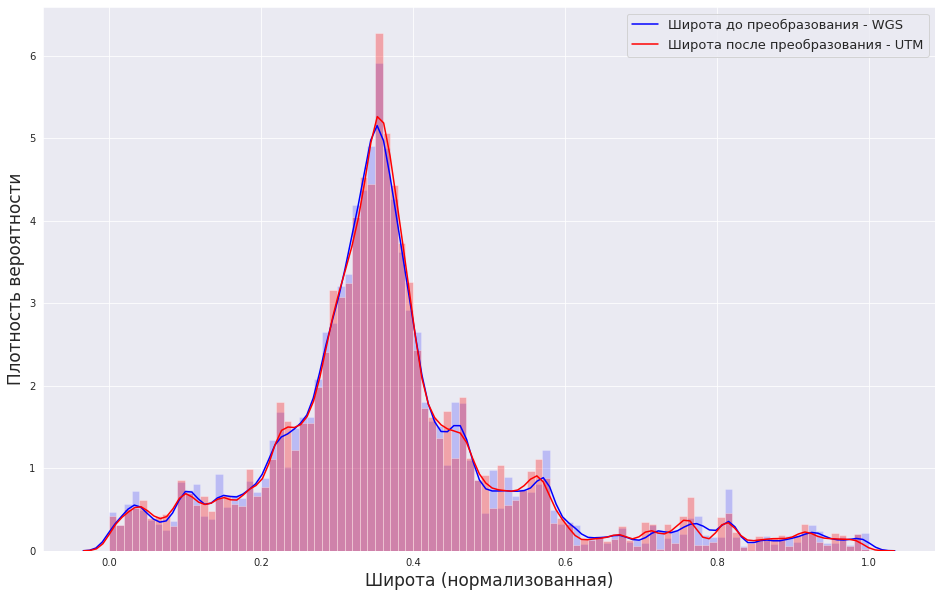

In [74]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 10

scaler1 = MinMaxScaler()
utm_latitude = np.array(train_data['utm_latitude'])
utm_latitude = utm_latitude.reshape((len(utm_latitude),1))
utm_latitude_scaled = scaler1.fit_transform(utm_latitude)
utm_latitude_scaled = np.ravel(utm_latitude_scaled)

scaler2 = MinMaxScaler()
place_latitude = np.array(train_data['place_latitude'])
place_latitude = place_latitude.reshape((len(place_latitude),1))
place_latitude_scaled = scaler2.fit_transform(place_latitude)
place_latitude_scaled = np.ravel(place_latitude_scaled)

# Повторим процедуру для других долготы
scaler1 = MinMaxScaler()
utm_longitude = np.array(train_data['utm_longitude'])
utm_longitude = utm_longitude.reshape((len(utm_longitude),1))
utm_longitude_scaled = scaler1.fit_transform(utm_longitude)
utm_longitude_scaled = np.ravel(utm_longitude_scaled)

scaler2 = MinMaxScaler()
place_longitude = np.array(train_data['place_longitude'])
place_longitude = place_longitude.reshape((len(place_longitude),1))
place_longitude_scaled = scaler2.fit_transform(place_longitude)
place_longitude_scaled = np.ravel(place_longitude_scaled)

with sns.axes_style("darkgrid"):
    
    plt.hist(place_latitude_scaled, 100, density = True, color = 'blue', alpha = 0.2)
    sns.kdeplot(place_latitude_scaled, shade = False, color = 'blue',  kernel = 'gau', alpha = 1.0,
                label = 'Широта до преобразования - WGS')
    plt.hist(utm_latitude_scaled, 100, density = True, color = 'red', alpha = 0.3)
    sns.kdeplot(utm_latitude_scaled, shade = False, color = 'red',  kernel = 'gau', alpha = 1.0, 
                label = 'Широта после преобразования - UTM')
    plt.ylabel('Плотность вероятности', fontsize = 17)
    plt.xlabel('Широта (нормализованная)', fontsize = 17)
    plt.legend(fontsize = 13)
    plt.show()

##### Координаты были переведены в метрическую проекцию, после чего была выдвинута гипотеза: 

- Преобразование повлияло на распределение координат и на конфигурацию координатной сетки

Таким образом, выборки, состоящие из исходных и преобразованных координат были нормализованы. Для выборок исходных и преобразованных координат произведем тестирование с целью проверки на принадлежность двух выборок одной генеральной совокупности. Подобное тестирование произведем и для координат долготы.

Для этого используем критерий Колмогорова-Смирнова. И, так как будет сделано только 2 сравнения, поэтому поправку на множественное тестирование вводить не будем.

In [75]:
scipy.stats.ks_2samp(utm_latitude_scaled, place_latitude_scaled)

Ks_2sampResult(statistic=0.013884100251956022, pvalue=9.723930097005548e-07)

Как видно по результатам теста на проверку принадлежности двух выборок utm_latitude_scaled и place_latitude_scaled одной генеральной совокупности (значение статистики больше, чем значение pvalue) - выборки значимо отличаются.

Проделаем ту же самую процедуру для долготы.

In [76]:
scipy.stats.ks_2samp(utm_longitude_scaled, place_longitude_scaled)

Ks_2sampResult(statistic=0.046558811828669944, pvalue=2.0313497075335857e-71)

Для долготы ситуация такая же - выборки отлчаются. Еще по форме кривой на графике и очень маленькому значению pvalue мы можем заключить, что распределение параметра отлично от нормального (собственно, поэтому мы и использовали именно критерий Колмогорова-Смирнова).

## 8. Синтез нового признака - время, прошедшее с начала предыдущего отключения станции (в минутах)

In [77]:
abs_time_start = np.array(train_data['abs_time_start'])
utm_longitude = np.array(train_data['utm_longitude'])
utm_latitude = np.array(train_data['utm_latitude'])

values = []
for index in range(0, len(abs_time_start)):
    # Первый элемент мы будем заполнять значением -100.0
    if index == 0:
        value = -100.0
    else:
        # Берем прошлое и текущее значение координат
        past_long = utm_longitude[index - 1]
        past_lat = utm_latitude[index - 1]

        current_long = utm_longitude[index]
        current_lat = utm_latitude[index]
        
        # Временная отметка начала сбоя (её текущее значение)
        current_time_start = abs_time_start[index]        
        # Временная отметка начала сбоя (её прошлое значение - начало предыдущего сбоя)
        past_time_start = abs_time_start[index - 1]
        
        # Если значение широты и долготы совпадает, то мы имеем дело с одной и той же станцией
        if current_long == past_long:
            if current_lat == past_lat:
                # Рассчитываем значение времени с последнего сбоя для данной станции
                value = current_time_start - past_time_start
            else:
                value = -100.0
        else:
            value = -100.0
            
    values.append(value)

train_data['values'] = values

# Удаляем строки со значением -100.0
train_data = train_data.replace(-100.0, np.nan)
train_data = train_data.dropna()
print('Размер датасета -', train_data.shape)
train_data.head(5)

Размер датасета - (67280, 12)


,place_longitude,place_latitude,time_start,time_end,outage,hour,year_and_month,outage_hours,abs_time_start,utm_latitude,utm_longitude,values
1,111.01,31.96447,2018-03-30 09:16:33,2018-03-30 10:33:58,77.416667,1,2018-03,1.290278,130156.550000,3.536498e+06,500944.917507,25611.833333
2,111.01,31.96447,2018-07-24 10:18:12,2018-07-24 11:05:42,47.500000,1,2018-07,0.791667,297258.200000,3.536498e+06,500944.917507,167101.650000
3,111.01,31.96447,2018-07-25 15:25:34,2018-07-25 16:22:57,57.383333,2,2018-07,0.956389,299005.566667,3.536498e+06,500944.917507,1747.366667
4,111.01,31.96447,2018-09-19 11:57:56,2018-09-19 13:09:44,71.800000,1,2018-09,1.196667,379437.933333,3.536498e+06,500944.917507,80432.366667
5,111.01,31.96447,2018-10-01 10:05:27,2018-10-02 01:49:43,944.266667,1,2018-10,15.737778,396605.450000,3.536498e+06,500944.917507,17167.516667


Визуализируем зависимость между продолжительностью отключения и временем, прошедшим с начала предыдущего отключения.

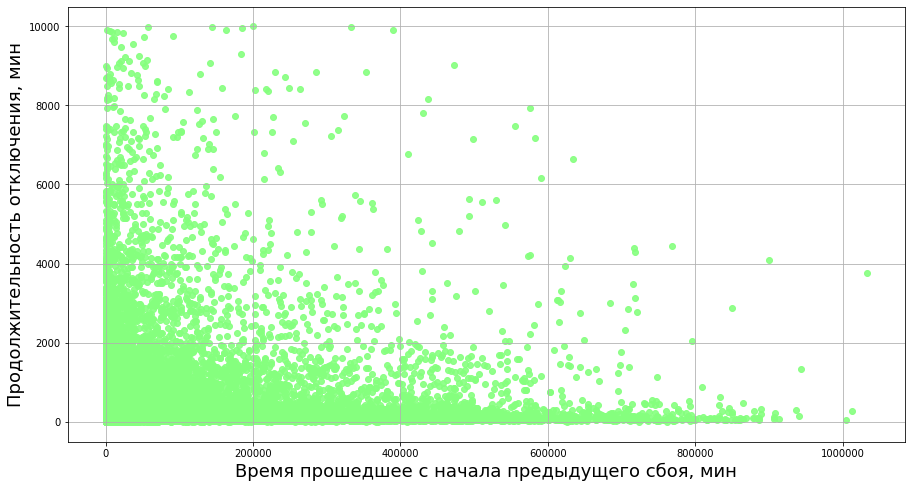

In [78]:
rcParams['figure.figsize'] = 15, 8

plt.scatter(train_data['values'], train_data['outage'], c = '#85FF7E', alpha = 0.9)
plt.xlabel('Время прошедшее с начала предыдущего сбоя, мин', fontsize = 18)
plt.ylabel('Продолжительность отключения, мин', fontsize = 18)
plt.grid()
plt.show()

## 9. Нормализация данных и подготовка признаков для обучения алгоритма

Категориальный признак кодируется, к вещественным применяется процедура стандартизации, так как метод опорных векторов чувствителен к масштабу данных (а в исходном виде мы имеем данные в двух размерностях – метры и минуты).

In [79]:
# Декодируем категориальный признак
cat_data = pd.DataFrame(train_data['hour'])
encoder = DV(sparse = False)
encoded_data = encoder.fit_transform(cat_data.T.to_dict().values())
# Нам придется подправить форму матриц
encoded_data = np.array(encoded_data).reshape((len(encoded_data), 4))

# Подготовим вещественные данные
scaler = StandardScaler()
X_train_num = scaler.fit_transform(train_data[['utm_latitude', 'utm_longitude', 'values']])
X_train_num = np.array(X_train_num).reshape((-1, 3))
# Отклики 
y_train = np.array(train_data['outage'])     

# Объединяем вещественные и категориальные предикторы
X_train = np.hstack((encoded_data, X_train_num))

## 10. Обучение алгоритма с отсевом выбросов

##### Основной алгоритм - Основной алгоритм – Метод опорных векторов с использованием алгоритма исключения выбросов RANSAC (RAndom SAmple Consensus - консенсус на основе случайных образцов)

В качестве предикторов используется 3 вещественных признака:

- Координата широты станции (координатная система UTM), м

- Координата долготы станции (координатная система UTM), м

- Время, прошедшее с начала предыдущего сбоя на станции, мин

А также один категориальный признак - время начала сбоя:

- Ночные часы и раннее утро

- Утро и день

- Вторая половина дня и начало вечера

- Вечернее время

(Все гиперпараметры были подобраны заранее)

In [80]:
# Обучим модель
SVR_ransac = RANSACRegressor(SVR(kernel = 'rbf', gamma = 'scale', C = 11, epsilon = 2.5), 
                             min_samples = 100, random_state = 12, max_trials = 100, residual_threshold = 500)
SVR_ransac.fit(X_train, y_train)

RANSACRegressor(base_estimator=SVR(C=11, cache_size=200, coef0=0.0, degree=3,
                                   epsilon=2.5, gamma='scale', kernel='rbf',
                                   max_iter=-1, shrinking=True, tol=0.001,
                                   verbose=False),
                is_data_valid=None, is_model_valid=None, loss='absolute_loss',
                max_skips=inf, max_trials=100, min_samples=100, random_state=12,
                residual_threshold=500, stop_n_inliers=inf,
                stop_probability=0.99, stop_score=inf)

## 11. Подготовка тестовой выборки. Алгоритм для оценки времени, прошедшего с начала предыдущего сбоя

Тренировочная выборка уже отсортирована в нужном порядке, поэтому мы сделаем следующее: возьмем информацию ТОЛЬКО об окончании последнего произошедшего сбоя. 

In [81]:
new_train_data = train_data.groupby(['utm_longitude', 'utm_latitude']).agg({'abs_time_start': 'last'})
new_train_data = new_train_data.reset_index()
new_train_data.head(5)

,utm_longitude,utm_latitude,abs_time_start
0,500944.917507,3.536498e+06,1.035727e+06
1,501897.523399,3.265267e+06,1.035394e+06
2,503723.721308,3.032534e+06,7.631603e+05
3,504071.435347,3.117687e+06,9.037915e+05
4,504663.236955,3.414974e+06,1.035581e+06


Теперь обучим алгоритм K-ближайших соседей

In [82]:
# Теперь обучаем Knn для определения времени окончания последнего отключения
Knn_scaler = MinMaxScaler()
X_train = Knn_scaler.fit_transform(new_train_data[['utm_latitude', 'utm_longitude']])
y_train = np.array(new_train_data['abs_time_start'])   

Knn = KNeighborsRegressor(n_neighbors = 2)
Knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

Для чего это требуется?

После проведенных преобразований становится возможным использовать вспомогательный алгоритм – K-ближайших соседей, если время начала предыдущего сбоя для станции неизвестно. 

Чтобы получить значение признака «Время (в минутах), прошедшее с начала предыдущего сбоя на данной станции» для станции, координаты которой в обучающей выборке не встречались, используется алгоритм K-ближайших соседей, с помощью которого определяется время начала предыдущего сбоя в этой точке на основе данных о времени сбоя в ближайших (по координатам UTM) к «новому» объекту станций, в реализованном алгоритме используется 2 пространственных соседа.

## 12. Подготовка тестовой выборки

На данном этапе нужно:

- Перевести время начала и время окончания сбоя в абсолютные величины
- Перепроецировать координаты WGS в UTM
- Рассчитать время, прошедшее с окончания последнего отключения для данной территории / станции / группы станций

### Перевод времени в абсолютные величины

In [83]:
# Столбец с начальной точкой отсчета
start_point = []
for i in range(0, len(test_data['time_start'])):
    my_date = date(2017, 12, 30)
    start_point.append(my_date)
test_data['start_point'] = start_point
test_data['start_point'] = pd.to_datetime(test_data['start_point'])

# Теперь вычитаем значение столбца start_point из time_start - для времени начала сбоя
abs_time_start = test_data['time_start'] - test_data['start_point']
new_time_start = []
for i in abs_time_start:
    # Время в секундах
    sec_time = i.total_seconds()
    # Время в минутах
    min_time = sec_time/60
    new_time_start.append(min_time)    
test_data['abs_time_start'] = new_time_start

test_data.drop(columns = 'start_point', inplace = True)
test_data.head(5)

,place_longitude,place_latitude,time_start,time_end,outage,hour,year_and_month,outage_hours,abs_time_start
145,111.019580,29.517000,2020-01-01 13:21:59,2020-01-01 16:54:14,212.250000,1,2020-01,3.537500,1.054882e+06
146,111.019580,29.517000,2020-01-16 13:11:23,2020-01-16 15:08:22,116.983333,1,2020-01,1.949722,1.076471e+06
147,111.019580,29.517000,2020-01-29 09:03:37,2020-01-29 12:50:49,227.200000,1,2020-01,3.786667,1.094944e+06
161,111.037671,27.416188,2020-01-11 10:11:01,2020-01-11 11:18:10,67.150000,1,2020-01,1.119167,1.069091e+06
255,111.053890,31.264720,2020-01-22 10:00:51,2020-01-22 15:35:34,334.716667,1,2020-01,5.578611,1.084921e+06


### Проецирование координат

In [84]:
# Сначала широта 
min_lat = np.min(np.array(test_data['place_latitude']))
max_lat = np.max(np.array(test_data['place_latitude']))

# Теперь долгота
min_long = np.min(np.array(test_data['place_longitude']))
max_long = np.max(np.array(test_data['place_longitude']))

# Подгатавливаем словарь
extent_dictionary = {'min_lat': min_lat, 'min_long': min_long,'max_lat': max_lat, 'max_long': max_long}
fst = np.array(test_data['place_latitude'])
scnd = np.array(test_data['place_longitude'])
utm_lats, utm_longs = transform_wgs_to_utm(extent_dictionary, fst, scnd)

test_data['utm_latitude'] = utm_lats
test_data['utm_longitude'] = utm_longs

Код подобранной метрической проекции UTM - 32649


### Рассчет времени, которое прошло с начала предыдущего сбоя 

In [85]:
# Синтез нового признака - время, прошедшее с начала последнего отключения станции
abs_time_start = np.array(test_data['abs_time_start'])
utm_longitude = np.array(test_data['utm_longitude'])
utm_latitude = np.array(test_data['utm_latitude'])

values = []
for index in range(0, len(abs_time_start)):
    # Первый элемент мы будем заполнять значением -100.0
    if index == 0:
        # Так как в данном случае мы знаем только время наступления действующего сбоя, но не имеем
        # Информации о сбое предыдущем, то её мы должны как то оценить
        features = Knn_scaler.transform([[utm_latitude[index], utm_longitude[index]]])
        # Оцениваем время начала предыдущего сбоя
        past_time_start = Knn.predict(features)
        past_time_start = past_time_start[0]
        current_time_start = abs_time_start[index]

        value = current_time_start - past_time_start
    else:
        # Берем прошлое и текущее значение координат
        past_long = utm_longitude[index - 1]
        past_lat = utm_latitude[index - 1]

        current_long = utm_longitude[index]
        current_lat = utm_latitude[index]

        # Временная отметка начала сбоя (её текущее значение)
        current_time_start = abs_time_start[index]
        # Временная отметка начала сбоя (её прошлое значение)
        past_time_start = abs_time_start[index - 1]

        # Если значение широты и долготы совпадает, то мы имеем дело с одной и той же станцией
        if current_long == past_long:
            if current_lat == past_lat:
                # Рассчитываем значение времени с последнего сбоя для данной станции
                value = current_time_start - past_time_start
            else:
                # Так как в данном случае мы знаем только время наступления действующего сбоя, но не имеем
                # Информации о сбое предыдущем, то её мы должны как то оценить
                features = Knn_scaler.transform([[utm_latitude[index], utm_longitude[index]]])
                # Оцениваем время начала предыдущего сбоя
                past_time_start = Knn.predict(features)
                past_time_start = past_time_start[0]
                current_time_start = abs_time_start[index]

                value = current_time_start - past_time_start
        else:
            # Так как в данном случае мы знаем только время наступления действующего сбоя, но не имеем
            # Информации о сбое предыдущем, то её мы должны как то оценить
            features = Knn_scaler.transform([[utm_latitude[index], utm_longitude[index]]])
            # Оцениваем время начала предыдущего сбоя
            past_time_start = Knn.predict(features)
            past_time_start = past_time_start[0]
            current_time_start = abs_time_start[index]

            value = current_time_start - past_time_start

    values.append(value)
    
test_data['values'] = values

## 13. Валидация модели

Теперь у нас есть все необходимое, чтобы сделать прогноз

In [86]:
# Препроцессинг данных
X_test_num = scaler.transform(test_data[['utm_latitude', 'utm_longitude', 'values']])
X_test_num = np.array(X_test_num).reshape((-1, 3))
y_test = np.array(test_data['outage']) 

cat_data = pd.DataFrame(test_data['hour'])
X_test_cat = encoder.transform(cat_data.T.to_dict().values())
X_test_cat = np.array(X_test_cat).reshape((len(X_test_cat), 4))
X_test = np.hstack((X_test_cat, X_test_num))

In [90]:
# Зададим необходимые функции
# Расчет метрики - cредняя абсолютная процентная ошибка
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)
    # У представленной ниже формулы есть недостаток, - если в массиве y_true есть хотя бы одно значение 0.0,
    # то по формуле np.mean(np.abs((y_true - y_pred) / y_true)) * 100 мы получаем inf, поэтому
    zero_indexes = np.argwhere(y_true == 0.0)
    for index in zero_indexes:
        y_true[index] = 0.01
    value = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return(value)

# Зададим функцию, которая будет выводить на экран значения метрик
def print_metrics(y_test, prediction, model, r2 = False):
    print('Средняя абсолютная ошибка на тестовой выборке -', mean_absolute_error(y_test, prediction))
    print('Средняя медианная ошибка на тестовой выборке -', median_absolute_error(y_test, prediction))
    print('Корень из среднеквадратической ошибки на тестовой выборке -', mean_squared_error(y_test, prediction)**0.5)
    print('Средняя абсолютная процентная ошибка на тестовой выборке -',mean_absolute_percentage_error(y_test, prediction))
    if r2 == True:
        print('Коэффициент детерминации на обучающей выборке -', r2_score(y_train, model.predict(X_train)))

# Зададим функцию для отрисовки графиков
def residuals_plots(y_test, prediction, color = 'blue'):
    prediction = np.ravel(prediction)
    y_test = np.ravel(y_test)
    # Рассчитываем ошибки
    errors = prediction - y_test
    errors = np.ravel(errors)
    with sns.axes_style("darkgrid"):
        sns.kdeplot(errors, shade = True, color = color,  kernel = 'gau', alpha = 0.6)
        plt.title('Распределение ошибок модели')
        plt.ylabel('Плотность вероятности', fontsize = 17)
        plt.xlabel('Ошибки', fontsize = 17)
        plt.show()

    plt.scatter(prediction, errors, c = color, alpha = 0.6, s = 6)
    plt.title('График остатков модели')
    plt.xlabel('Предсказанное значение продолжительности отключения, мин', fontsize = 15)
    plt.ylabel('Исходные остатки', fontsize = 15)
    plt.grid()
    plt.show()

Средняя абсолютная ошибка на тестовой выборке - 141.97629206481128
Средняя медианная ошибка на тестовой выборке - 60.80097916600748
Корень из среднеквадратической ошибки на тестовой выборке - 286.3531659047387
Средняя абсолютная процентная ошибка на тестовой выборке - 112.39559213660439


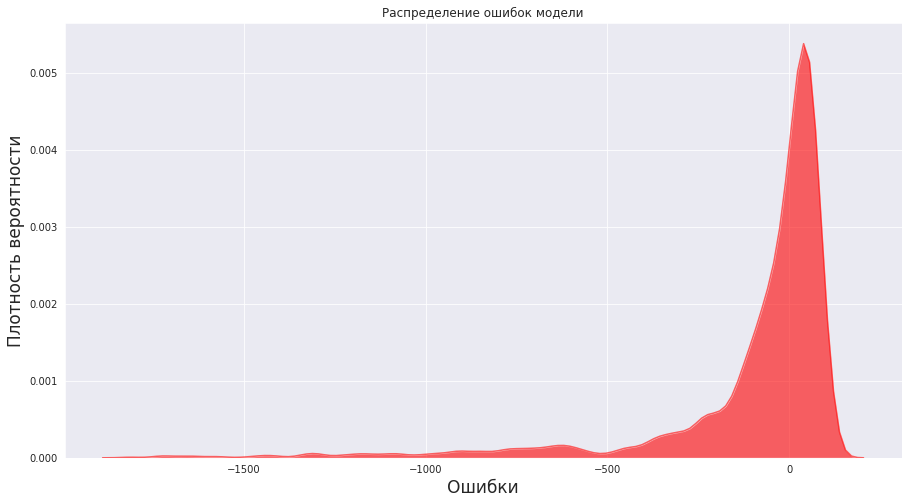

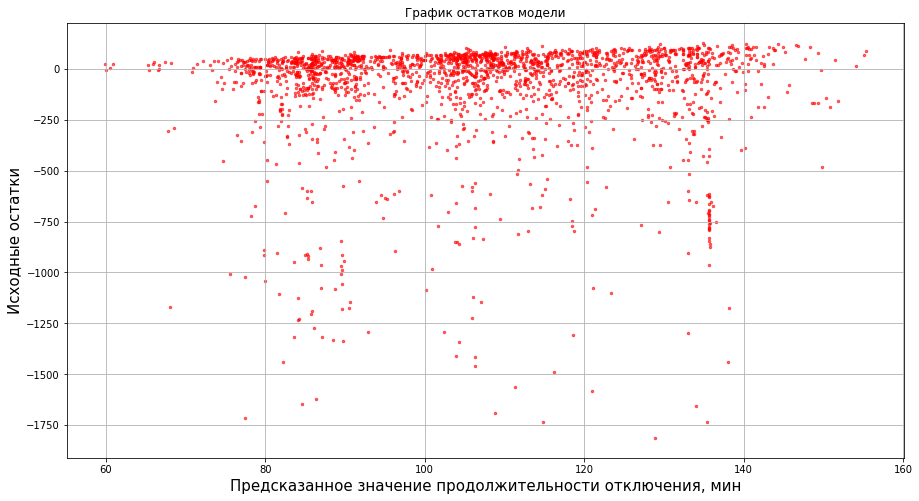

In [91]:
model_prediction = SVR_ransac.predict(X_test)

rcParams['figure.figsize'] = 15, 8
print_metrics(y_test, model_prediction, SVR_ransac, r2 = False)
residuals_plots(y_test, model_prediction, color = 'red')

Можно заключить, что остатки смещены, но условие гомоскедастичности соблюдается.

## 14. Использование алгоритма для проведения симуляций

Алгоритм пригоден для проведения симуляций, при варьировании входных параметров: времени, прошедшего с начала предыдущих сбоев на станциях и категориального предиктора – времени суток начала сбоя – будет получена смоделированная поверхность с предполагаемой продолжительностью отключения для каждой ячейки территории.

In [99]:
# Определим границы зоны, в которой требуется производить моделирование
# Широта UTM
utm_latitude_min = np.min(np.array(train_data['utm_latitude']))
utm_latitude_max = np.max(np.array(train_data['utm_latitude']))
# Долгота UTM
utm_longitude_min = np.min(np.array(train_data['utm_longitude']))
utm_longitude_max = np.max(np.array(train_data['utm_longitude']))

# Широта WGS
wgs_latitude_min = np.min(np.array(train_data['place_latitude']))
wgs_latitude_max = np.max(np.array(train_data['place_latitude']))
# Долгота WGS
wgs_longitude_min = np.min(np.array(train_data['place_longitude']))
wgs_longitude_max = np.max(np.array(train_data['place_longitude']))

Генерируем сетку для моделирования

In [104]:
# Сгенерируем ряды с координатами - UTM
new_latitude = np.linspace(utm_latitude_min, utm_latitude_max, num = 200)
new_longitude = np.linspace(utm_longitude_min, utm_longitude_max, num = 200)
# Теперь совместим наши координаты
new_latitude = list(new_latitude)*200
new_longitude = np.repeat(new_longitude, 200)

# Сгенерируем ряды с координатами - WGS
wgs_latitude = np.linspace(wgs_latitude_min, wgs_latitude_max, num = 200)
wgs_longitude = np.linspace(wgs_longitude_min, wgs_longitude_max, num = 200)
# Теперь совместим наши координаты
wgs_latitude = list(wgs_latitude)*200
wgs_longitude = np.repeat(wgs_longitude, 200)

#### Функция для имитационного моделирования

Аргументы:
* new_latitude - массив из широт UTM
* new_longitude - массив из долгот UTM
* wgs_latitude - массив из широт WGS
* wgs_longitude - массив из долгот WGS
* model - прогнозная обученная модель
* scaler - стандартизатор
* day_time - время суток начала сбоя ('0', '1', '2' или '3')
* time_after - время (в минутах), прошедшее с начала последнего сбоя

В результате работы функции формируется прогноз на заданную сетку. Результат прогнозирования отображается в виде графика смоделированной поверхности.

In [138]:
def simulation(new_latitude, new_longitude, wgs_latitude, wgs_longitude, model, scaler, day_time, time_after):
    # Массив со значениями признака - время суток начала сбоя
    modeled_hours = np.full(len(wgs_longitude), day_time)
    
    # Массив со значением времени (в минутах), которое прошло с начала предыдущих сбоев
    modeled_values = np.full(len(wgs_longitude), time_after)
    
    # Составим датасет из выбранных значений
    new_data = pd.DataFrame({'new_latitude': new_latitude,
                         'new_longitude': new_longitude,
                         'wgs_latitude': wgs_latitude,
                         'wgs_longitude': wgs_longitude,
                         'modeled_hours': modeled_hours,
                         'modeled_values': modeled_values})
    
    # Декодировка категориальных признаков
    cat_data = pd.DataFrame({'Время_суток': ['0','1','2','3']})
    encoder = DV(sparse = False)
    # "Обучаем" наш кодировщик
    encoder.fit(cat_data.T.to_dict().values())

    # Подаем ему на вход наши данные
    cat_data = pd.DataFrame(new_data['modeled_hours'])
    encoded_data = encoder.transform(cat_data.T.to_dict().values())
    # Нам придется подправить форму матриц
    encoded_data = np.array(encoded_data).reshape((len(encoded_data), 4))

    # Подготовим вещественные признаки
    X_num = scaler.transform(new_data[['new_latitude', 'new_longitude', 'modeled_values']])
    X_num = np.array(X_num).reshape((-1, 3))     

    # Объединяем вещественные и категориальные предикторы
    X = np.hstack((encoded_data, X_num))

    # Делаем прогноз
    y = model.predict(X)
    # Записываем прогноз в датасет
    new_data['predicted_data'] = y
    
    # Визуализация результата
    rcParams['figure.figsize'] = 10, 8
    fig = pyplot.figure()
    ax = Axes3D(fig)

    x_vals = np.array(new_data['wgs_latitude'])
    y_vals = np.array(new_data['wgs_longitude'])
    z_vals = np.array(new_data['predicted_data'])
    points = np.ravel(z_vals )

    surf = ax.scatter(x_vals, y_vals,z_vals, c=points, cmap='rainbow')
    ax.set_zlabel('Продолжительность отключения, мин')
    ax.view_init(75, 115)
    fig.colorbar(surf, shrink = 0.5, aspect = 10)
    plt.xlabel('Широта, градусы (WGS)')
    plt.ylabel('Долгота, градусы (WGS)')
    plt.title('Смоделированная поверхность')
    pyplot.show()
    pass

Произведем симуляцию. Будем рассматривать ночные часы и раннее утро (параметр day_time равен '0'). 

Представим, что нас интересует то, насколько стоит ожидать отключения, если последний раз станции отключались 1500 минут назад.

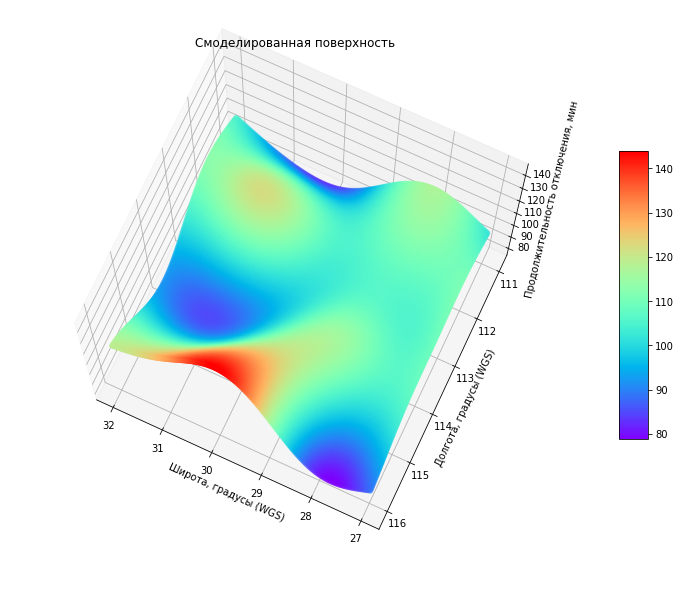

In [139]:
simulation(new_latitude, new_longitude, wgs_latitude, wgs_longitude, SVR_ransac, scaler,
           day_time = '0', time_after = 1500)